**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

# Data Preparation

In [ ]:
from sklearn.datasets import load_breast_cancer

frame = load_breast_cancer(as_frame=True)
df = frame['data']
X = df.values
y = np.array(frame['target'])

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
scaler = MinMaxScaler()

In [ ]:
X = scaler.fit_transform(X)

# X-Means

https://github.com/annoviko/pyclustering/

In [ ]:
#!pip install pyclustering

In [ ]:
from pyclustering.cluster import xmeans

In [ ]:
xm = xmeans.xmeans(X)
xm.process()

In [ ]:
clusters = xm.get_clusters()

In [ ]:
def clusters_to_labels(clusters):
    labels = np.empty(shape=(len(np.concatenate(clusters))), dtype=int)
    for i in range(len(clusters)):
        for idx in clusters[i]:
            labels[idx] = i
    return labels

In [ ]:
labels = clusters_to_labels(clusters)

In [ ]:
centers = np.array(xm.get_centers())
centers_unscaled = scaler.inverse_transform(centers)

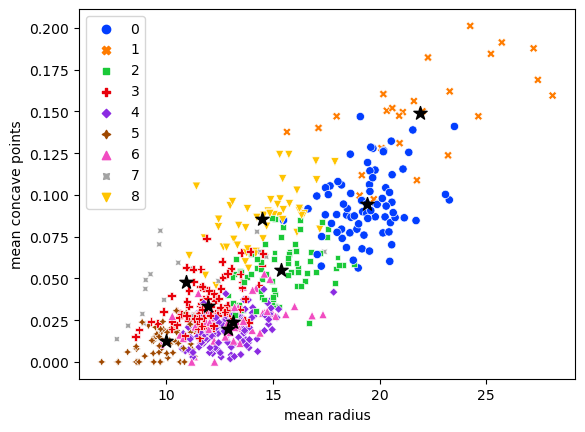

In [ ]:
sns.scatterplot(data=df, x="mean radius", y="mean concave points", hue=labels, palette="bright", style=labels)
plt.scatter(centers_unscaled[:, 0], centers_unscaled[:,7], color="black", marker="*", s=100)

# BISECTING K-MEANS

In [ ]:
from sklearn.cluster import BisectingKMeans

In [ ]:
bkmeans = BisectingKMeans(n_clusters=8)
bkmeans.fit(X)

BisectingKMeans()

<AxesSubplot:xlabel='mean radius', ylabel='mean concave points'>

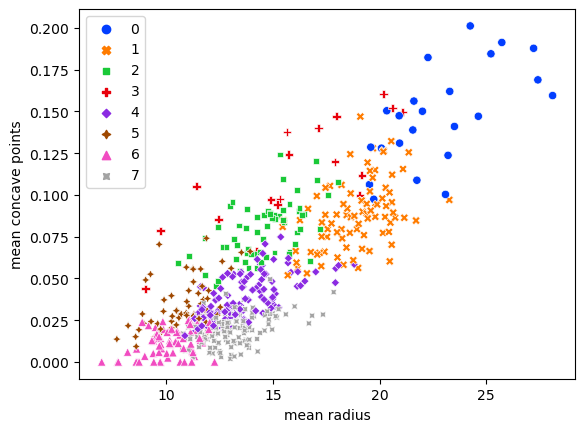

In [ ]:
sns.scatterplot(data=df, x="mean radius", y="mean concave points", hue=bkmeans.labels_, 
                palette="bright", style=bkmeans.labels_)

#### Silhouette plot

In [ ]:
# !pip install yellowbrick

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

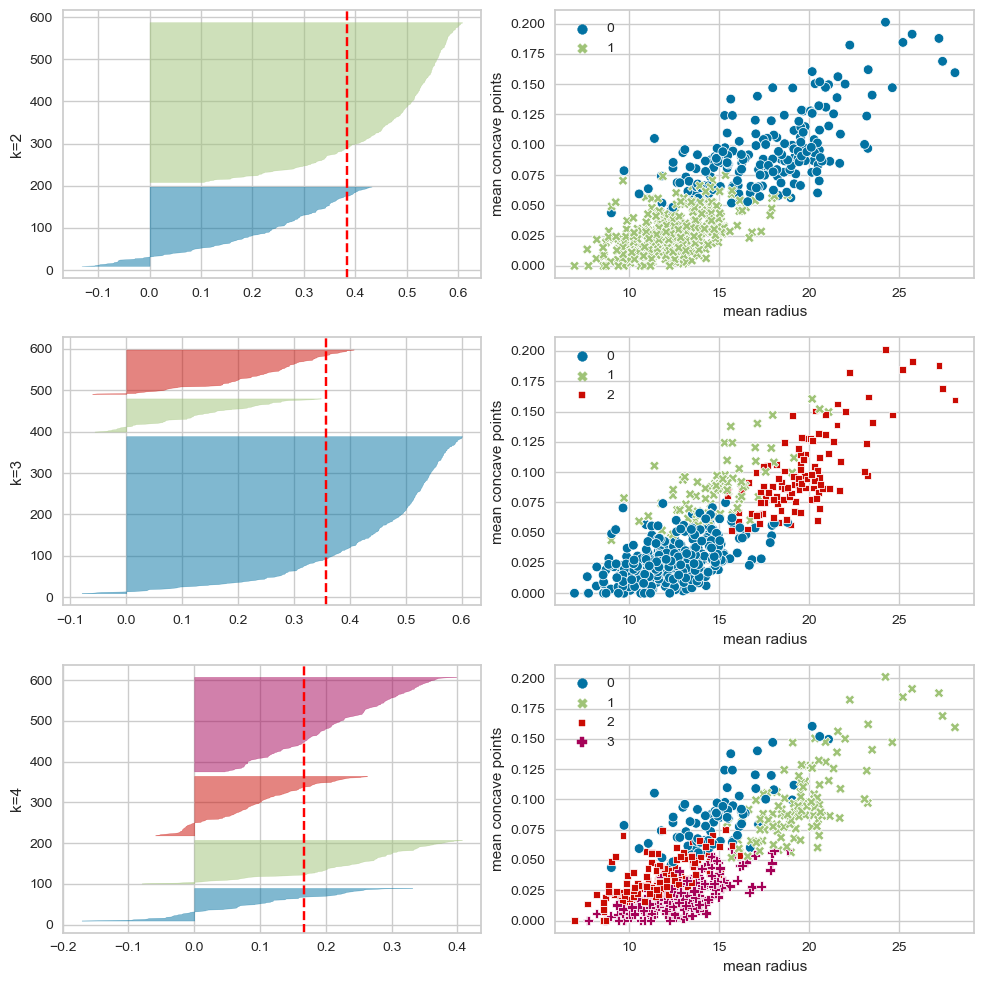

In [ ]:
colors=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
n_clust = 5
fig, axs = plt.subplots(n_clust-2, 2, figsize=(10,10))
for i in range(2, n_clust):
    bkmeans = BisectingKMeans(n_clusters=i)
    visualizer = SilhouetteVisualizer(bkmeans, colors=colors, ax=axs[i-2][0])
    axs[i-2][0].set_ylabel("k=" + str(i))
    visualizer.fit(X)
    sns.scatterplot(data=df, x="mean radius", y="mean concave points", hue=bkmeans.labels_, 
                    palette=sns.color_palette(colors[:i]), style=bkmeans.labels_, ax=axs[i-2][1])
plt.tight_layout()

In [ ]:
silhouette_score(X, bkmeans.labels_)

0.16723675902218899

# OPTICS

In [ ]:
from sklearn.cluster import OPTICS

In [ ]:
optics = OPTICS(min_samples=5, max_eps=np.inf)
optics.fit(X)

OPTICS()

In [ ]:
silhouette_score(X[optics.labels_ != -1], optics.labels_[optics.labels_ != -1])

0.29091187971598065

<AxesSubplot:xlabel='mean radius', ylabel='mean concave points'>

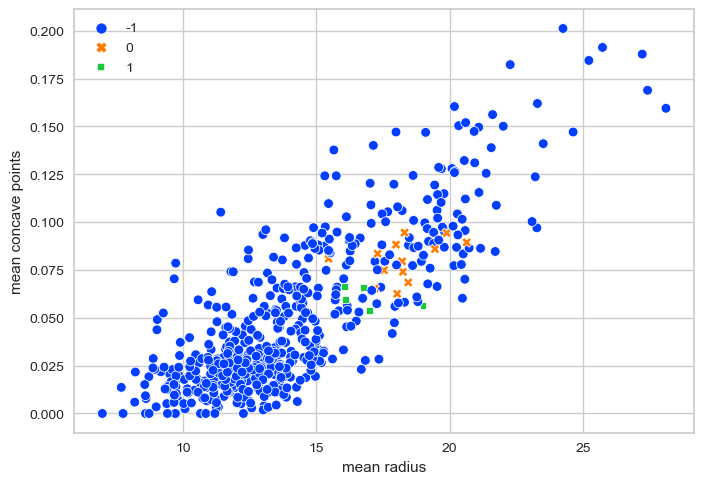

In [ ]:
sns.scatterplot(data=df, x="mean radius", y="mean concave points", hue=optics.labels_, 
                palette="bright", style=optics.labels_)

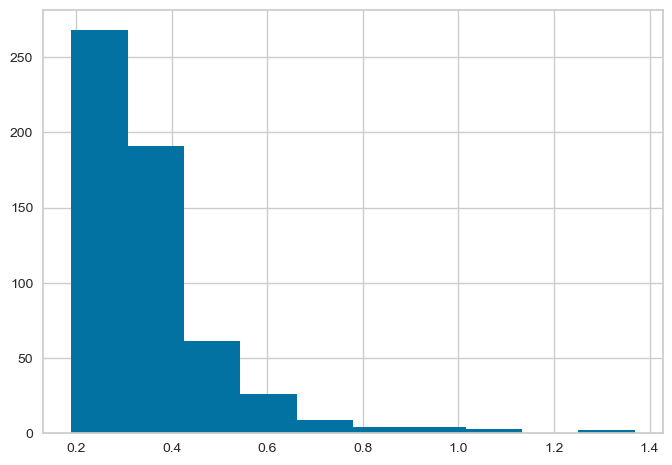

In [ ]:
plt.hist(optics.reachability_[1:])
plt.show()

In [ ]:
optics = OPTICS(min_samples=5, max_eps=np.inf, cluster_method='dbscan', eps=0.3)
optics.fit(X)

OPTICS(cluster_method='dbscan', eps=0.3)

In [ ]:
silhouette_score(X[optics.labels_ != -1], optics.labels_[optics.labels_ != -1])

0.07553499719530649

In [ ]:
np.unique(optics.labels_)

array([-1,  0,  1,  2,  3])

In [ ]:
np.unique(optics.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3]), array([316,  13, 231,   4,   5]))

In [ ]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_optics.html